# Hands-on Day 2

## You'll learn

### ML methods
- Gradient Boosting Trees with sklearn

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
#define number of events - to pick input file
evt = "100k"
#evt = "1M"

# read in input parquet file
input_file = "Higgs"+evt+".parquet"
%time df = pd.read_parquet(input_file)

CPU times: user 209 ms, sys: 205 ms, total: 414 ms
Wall time: 119 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

99999

# Data preprocessing

##  Exercise 1

- split x and y into training and test sets (80% training, 20% testing, randomly distributed)
- call them *x_train*, *x_test*, *y_train*, *y_test*
- you may use the sklearn built-in function

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

99999
99999


# ML models: GBT

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gbt = GradientBoostingClassifier()  

# Train the model with default hyperparameters (takes about 1m on 100k, 12m on 1M)
%time gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = gbt.predict(x_test)

CPU times: user 1min 5s, sys: 62.5 ms, total: 1min 5s
Wall time: 1min 5s


##  Exercise 2

- evaluate the gbt model by printing: accuracy, precision, F1, recall, confusion matrix
- you may use the sklearn built-in functions

In [8]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7176
Precision: 0.7312
Recall: 0.7420
F1-Score: 0.7365


In [9]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report) 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70      9358
         1.0       0.73      0.74      0.74     10642

    accuracy                           0.72     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.72      0.72      0.72     20000



In [10]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6455 2903]
 [2746 7896]]


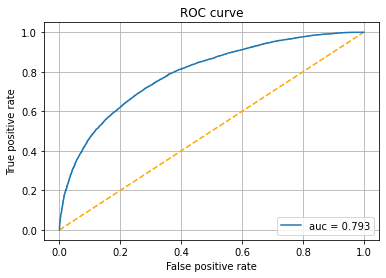

In [11]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

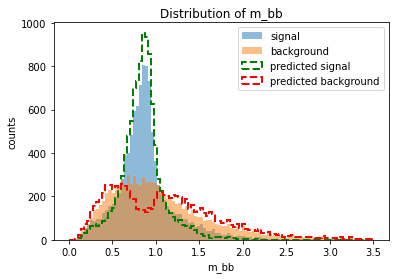

In [12]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.349847
27                    m_wwbb    0.133188
26                     m_wbb    0.130761
22                     m_jjj    0.101695
24                     m_jlv    0.081945
5                    jet1_pt    0.079847
0                  lepton_pT    0.035317
3   missing_energy_magnitude    0.029522
9                    jet2_pt    0.018239
21                      m_jj    0.013971
17                   jet4_pt    0.006377
23                      m_lv    0.006085
8                 jet1_b-tag    0.004761
13                   jet3_pt    0.004291
16                jet3_b-tag    0.001785
20                jet4_b-tag    0.000722
12                jet2_b-tag    0.000365
6                   jet1_eta    0.000354
10                  jet2_eta    0.000347
19                  jet4_phi    0.000272
14                  jet3_eta    0.000160
15                  jet3_phi    0.000088
18                   je4_eta 

<Figure size 720x432 with 0 Axes>

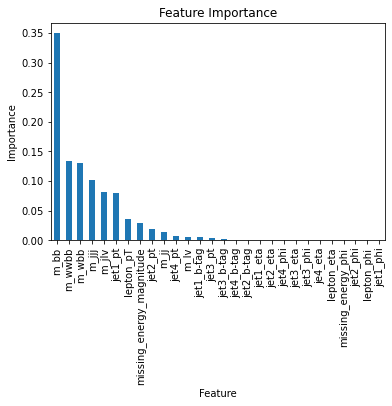

In [13]:
#draw feature importance
drawFeatures(x, gbt)

# Hyperparameter scan

In [14]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: deviance
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: None
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


## Exercise 3

- do hyperparameter optimisation on 100k evts
- select a reasonable number and range of hyperparameters
- do not USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid - takes 35 minutes with 100k evts
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7, 10]  # Maximum depth of each tree
}

# Initialize GridSearchCV with 5-fold cross-validation
# do not use n_jobs = -1 to use all available cores
grid_search = GridSearchCV(estimator=gbt, param_grid=param_grid, cv=5, 
                           scoring='accuracy', n_jobs=5) 

# Fit the grid search to the data
%time grid_search.fit(x_train, y_train)

# Print the best parameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(x_test, y_test)
print(f"Test Set Accuracy: {test_score:.4f}")

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

In [ ]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

In [ ]:
#draw feature importance
drawFeatures(x, best_model)

## Exercise 4

- use hyperparameters from best model to train on 1M events
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [ ]:
# read in input parquet file
input_file = "Higgs1M.parquet"
%time df = pd.read_parquet(input_file)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

In [ ]:
# train a model with best hyperparameters on 1M evts (45min)
best_gbt = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, 
                                      max_depth=5)
%time best_gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_gbt.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Get predicted probabilities for the positive class
y_scores = best_gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_scores, y_test)

In [ ]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

In [ ]:
#draw feature importance
drawFeatures(x, best_gbt)